# Task 2 User Engagement Analysis 
###### Under this task the user's engagement are tracked using the following metrics
* session frequency
* duration of the session
* the sessions total traffic(Download and Upload)

In [1]:
#importing the neccessary packages 
import os
import sys
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.io as pio
import plotly.express as px
import plotly. graph_objects as go
import matplotlib.pyplot as plt
from sklearn import preprocessing 
from sklearn.cluster import KMeans
from plotly.subplots import make_subplots
from sklearn.preprocessing import StandardScaler, normalize

In [2]:
# importing scripts files
sys.path.append(os.path.abspath(os.path.join('../scripts')))
from data_outlier import *
import plots

In [3]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
pd.set_option("expand_frame_repr", False)
pd.set_option('display.float_format', '{:.2f}'.format)

In [4]:
# loading cleaned dataset

cleaned_data = pd.read_csv('../data/cleaned_dataset.csv')
cleaned_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 148506 entries, 0 to 148505
Data columns (total 54 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   Unnamed: 0                      148506 non-null  int64  
 1   Unnamed:_0                      148506 non-null  int64  
 2   Bearer_Id                       148506 non-null  float64
 3   Start                           148506 non-null  object 
 4   Start_ms                        148506 non-null  float64
 5   End                             148506 non-null  object 
 6   End_ms                          148506 non-null  float64
 7   Dur._(ms)                       148506 non-null  float64
 8   IMSI                            148506 non-null  float64
 9   MSISDN_Number                   148506 non-null  float64
 10  IMEI                            148506 non-null  float64
 11  Last_Location_Name              148506 non-null  object 
 12  Avg_RTT_DL_(ms) 

### Task 2.1 Python script for the following task: 
  *  Aggregate the above metrics per customer id(MSISDN) and report the top customers per engagement metric
  * Normalize each engagement metric and run a k-means (k=3) to classify customers in three groups of engagement
  * Compute the minimum, maximum, average & total non-normalized metrics for each cluster. Interpret your results visually with accompanying text explaining your findings
  *  Aggregate user total traffic per application and derive the top 10 most engaged users per application
  * Top 3 most used Applications
  * Using k-means clustering algorithm, group users in k engagement clusters based on the engagement metrics.
      * What is the optimized value of k(use elbow method for this)?
      * Interpret your findings.

In [5]:
user_engagement_df = cleaned_data[['MSISDN_Number', 'Bearer_Id', 'Dur._(ms)', 'Total_Data_(Bytes)']].copy().rename(columns={
    'Bearer_Id': 'Session_Frequency', 'MSISDN_Number':'Customer_Id', 'Dur._(ms)': 'Duration', 'Total_Data_(Bytes)': 'Total_Data_Volume'})

In [6]:
#Aggregating Session_Frequency,Duration and Total_Data_Volume per Customer_Id and Displaying top 10 
user_engagement = user_engagement_df.groupby('Customer_Id').agg({'Session_Frequency': 'count', 'Duration': 'sum', 'Total_Data_Volume': 'sum'})
user_engagement.head(10)

,Session_Frequency,Duration,Total_Data_Volume
Customer_Id,,,
33601001722.00,1,116720.00,878690574.00
33601001754.00,1,181230.00,156859643.00
33601002511.00,1,134969.00,595966483.00
33601007832.00,1,49878.00,422320698.00
33601008617.00,2,37104.00,1457410944.00
33601010682.00,2,253983.00,615217221.00
33601011634.00,2,128360.00,654723066.00
33601011959.00,1,86399.00,332660357.00
33601014694.00,2,242249.00,990132189.00


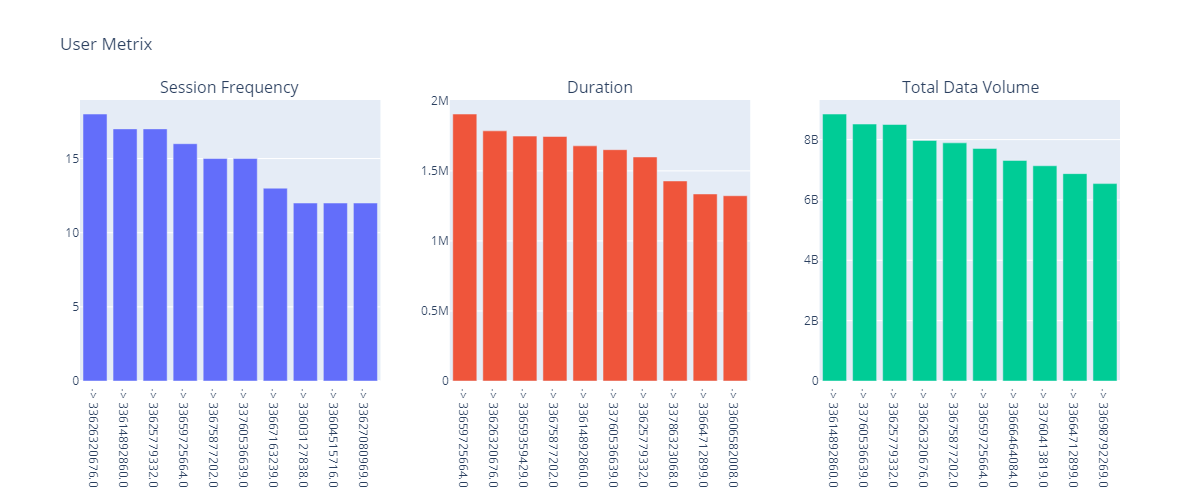

In [7]:
#Displaying top 10  customer engagement
sessions = user_engagement.nlargest(10, "Session_Frequency")['Session_Frequency']
duration = user_engagement.nlargest(10, "Duration")['Duration']
total_data_volume = user_engagement.nlargest(10, "Total_Data_Volume")['Total_Data_Volume']

plots.mult_hist([sessions, duration, total_data_volume], 1,
          3, "User Metrix", ['Session Frequency', 'Duration', 'Total Data Volume'])

<AxesSubplot:>

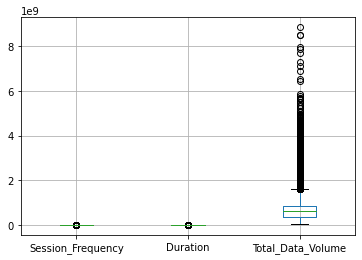

In [8]:
# Check for outliers 

user_engagement.boxplot()

In [9]:
#Normalize the Engagement Metrics
scaler = StandardScaler()
scaled_array = scaler.fit_transform(user_engagement)
pd.DataFrame(scaled_array).head(5)

,0,1,2
0,-0.49,-0.12,0.38
1,-0.49,0.52,-1.09
2,-0.49,0.06,-0.19
3,-0.49,-0.78,-0.55
4,0.75,-0.91,1.56


In [10]:
data_normalized = normalize(scaled_array)
pd.DataFrame(data_normalized).head(5)

,0,1,2
0,-0.78,-0.18,0.60
1,-0.38,0.40,-0.83
2,-0.92,0.12,-0.37
3,-0.46,-0.73,-0.51
4,0.38,-0.46,0.80


In [11]:
# K=3 to classify customers 
kmeans = KMeans(n_clusters=3, random_state=0).fit(data_normalized)
kmeans.labels_

array([0, 2, 2, ..., 2, 0, 2])

In [12]:
user_engagement.insert(0, 'Cluster', kmeans.labels_)
user_engagement.head(5)

,Cluster,Session_Frequency,Duration,Total_Data_Volume
Customer_Id,,,,
33601001722.00,0,1,116720.00,878690574.00
33601001754.00,2,1,181230.00,156859643.00
33601002511.00,2,1,134969.00,595966483.00
33601007832.00,2,1,49878.00,422320698.00
33601008617.00,1,2,37104.00,1457410944.00


In [13]:
user_engagement['Cluster'].value_counts()

2    43852
0    32686
1    29933
Name: Cluster, dtype: int64

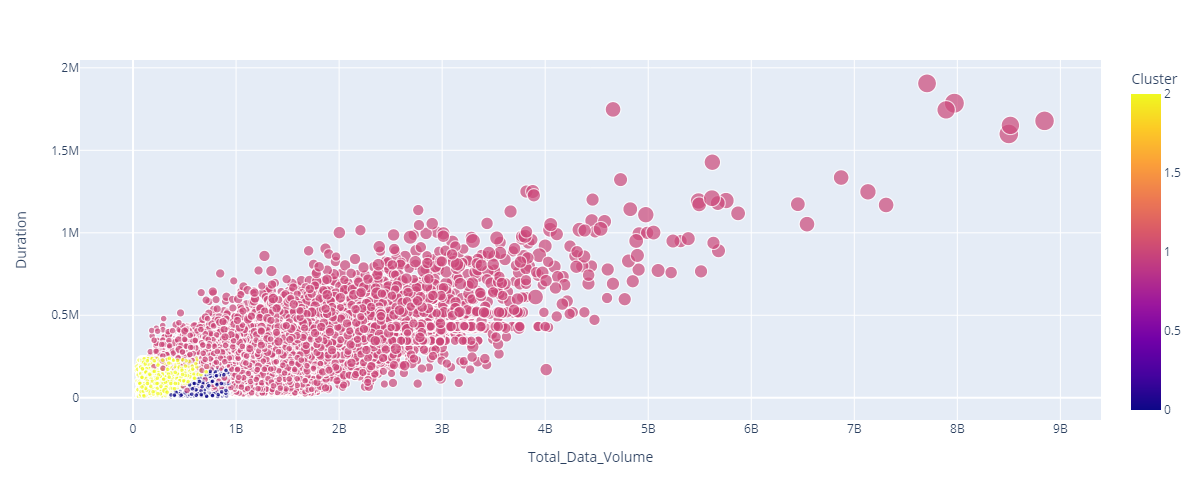

In [15]:
from IPython.display import Image
fig = px.scatter(user_engagement, x='Total_Data_Volume', y="Duration", color='Cluster', size='Session_Frequency')
Image(pio.to_image(fig, format='png', width=1200))

In [16]:
#Compute the minimum, maximum, average & total non-normalized metrics for each cluster. 
#Interpret your results visually with accompanying text explaining your findings
cluster1 = user_engagement[user_engagement["Cluster"]==0]
cluster1.describe()

,Cluster,Session_Frequency,Duration,Total_Data_Volume
count,32686.00,32686.00,32686.00,32686.00
mean,0.00,1.00,71703.52,707309702.43
std,0.00,0.03,40187.83,137478556.75
min,0.00,1.00,7142.00,322837943.00
25%,0.00,1.00,33105.75,608415307.50
50%,0.00,1.00,85499.00,722877583.50
75%,0.00,1.00,91022.00,821206183.25
max,0.00,2.00,177331.00,950760661.00


In [17]:
cluster1 = user_engagement[user_engagement["Cluster"]==1]
cluster1.describe()

,Cluster,Session_Frequency,Duration,Total_Data_Volume
count,29933.00,29933.00,29933.00,29933.00
mean,1.00,2.39,221973.29,1205086884.56
std,0.00,0.96,132488.87,585500674.78
min,1.00,1.00,18235.00,157848933.00
25%,1.00,2.00,138808.00,826734977.00
50%,1.00,2.00,193444.00,1095900988.00
75%,1.00,3.00,277511.00,1452964650.00
max,1.00,18.00,1905478.00,8846226494.00


In [18]:
cluster1 = user_engagement[user_engagement["Cluster"]==2]
cluster1.describe()

,Cluster,Session_Frequency,Duration,Total_Data_Volume
count,43852.00,43852.00,43852.00,43852.00
mean,2.00,1.01,106912.32,329194099.80
std,0.00,0.09,50963.63,164339850.64
min,2.00,1.00,7189.00,33249009.00
25%,2.00,1.00,85449.75,193601510.00
50%,2.00,1.00,94419.00,312773103.50
75%,2.00,1.00,145837.25,448435511.00
max,2.00,2.00,241989.00,791756442.00


In [20]:
#Aggregate user total traffic per application and derive the top 10 most engaged users per application
app_df = cleaned_data.groupby('MSISDN_Number').agg({'Gaming_(Bytes)': 'sum', 'Youtube_(Bytes)': 'sum', 'Netflix_(Bytes)': 'sum',\
                     'Google_(Bytes)': 'sum', 'Email_(Bytes)': 'sum', 'Social_Media_(Bytes)': 'sum', 'Other_(Bytes)': 'sum'})
app_df.head()

,Gaming_(Bytes),Youtube_(Bytes),Netflix_(Bytes),Google_(Bytes),Email_(Bytes),Social_Media_(Bytes),Other_(Bytes)
MSISDN_Number,,,,,,,
33601001722.00,812458661.00,21624548.00,27180981.00,4389005.00,1331362.00,2232135.00,386570872.00
33601001754.00,119750078.00,12432223.00,11221763.00,5334863.00,3307781.00,2660565.00,281710071.00
33601002511.00,538827713.00,21333570.00,19353900.00,3443126.00,3205380.00,3195623.00,501693672.00
33601007832.00,391126127.00,6977321.00,1942092.00,9678493.00,2284670.00,280294.00,35279702.00
33601008617.00,1314797820.00,41533002.00,49201724.00,18499616.00,3305469.00,2912542.00,804804484.00


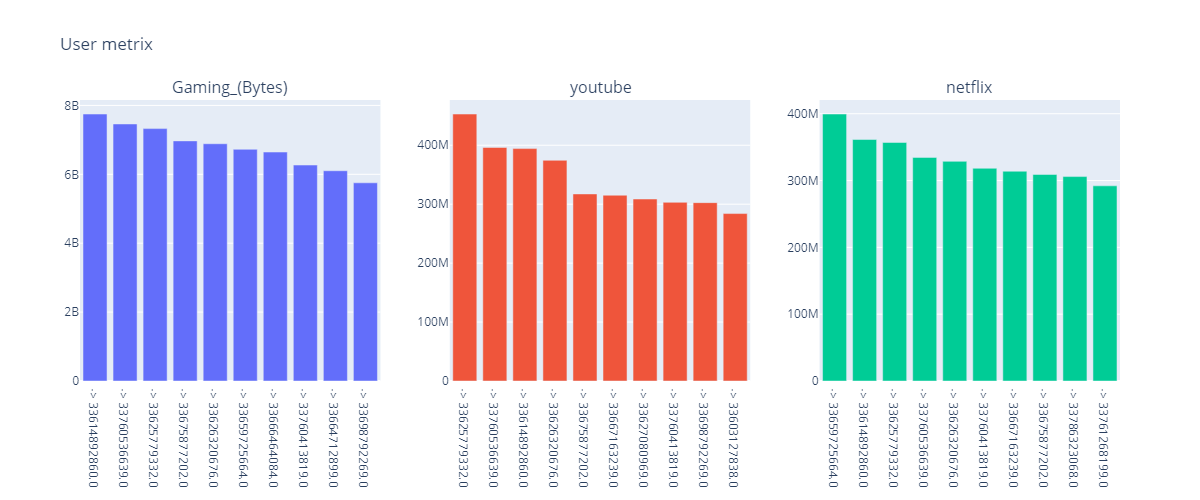

In [26]:
gaming = app_df.nlargest(10, "Gaming_(Bytes)")['Gaming_(Bytes)']
youtube = app_df.nlargest(10, "Youtube_(Bytes)")['Youtube_(Bytes)']
netflix = app_df.nlargest(10, "Netflix_(Bytes)")['Netflix_(Bytes)']
google = app_df.nlargest(10, "Google_(Bytes)")['Google_(Bytes)']
email = app_df.nlargest(10, "Email_(Bytes)")['Email_(Bytes)']
social_media = app_df.nlargest(10, "Social_Media_(Bytes)")['Social_Media_(Bytes)']
other = app_df.nlargest(10, "Other_(Bytes)")['Other_(Bytes)']


plots.mult_hist([gaming, youtube, netflix], 1,
          3, "User metrix", ["Gaming_(Bytes)", "youtube", "netflix"])

#plots.mult_hist([google, email, social_media, other], 1,
        #  4, "User Metrics", [ "Google", "Email", "Social Media", "Other"])

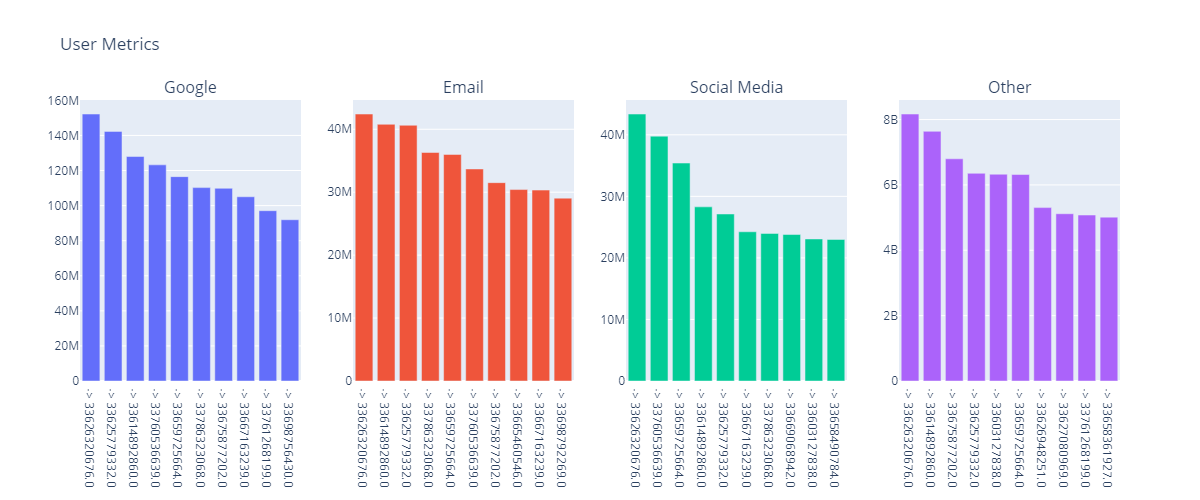

In [27]:
plots.mult_hist([google, email, social_media, other], 1,
         4, "User Metrics", [ "Google", "Email", "Social Media", "Other"])

###### Top 3 most used Applications

In [28]:
top_3 = app_df.sum()
top_3

Gaming_(Bytes)         63910124731666.00
Youtube_(Bytes)         3362537620065.00
Netflix_(Bytes)         3360563670772.00
Google_(Bytes)          1159544186717.00
Email_(Bytes)            335503000148.00
Social_Media_(Bytes)     271478798103.00
Other_(Bytes)          63770726326023.00
dtype: float64

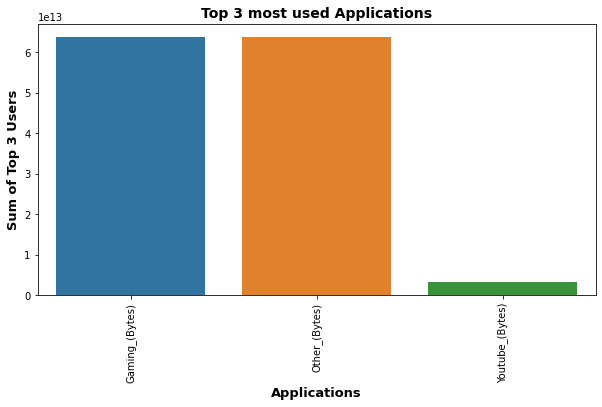

In [30]:
plots.plot_bar(top_3.nlargest(3), "Top 3 most used Applications", "Applications", "Sum of Top 3 Users")

In [35]:
#Distortion is the average of the euclidean squared distance from the centroid of the respective clusters. 
#Inertia is the sum of squared distances of samples to their closest cluster centre
from scipy.spatial.distance import cdist
def choose_kmeans(df: pd.DataFrame, num: int):
  distortions = []
  inertias = []
  K = range(1, num)
  for k in K:
    kmeans = KMeans(n_clusters=k, random_state=0).fit(df)
    distortions.append(sum(
        np.min(cdist(df, kmeans.cluster_centers_, 'euclidean'), axis=1)) / df.shape[0])
    inertias.append(kmeans.inertia_)


  return (distortions, inertias)

In [36]:
distortions, inertias = choose_kmeans(data_normalized, 15)

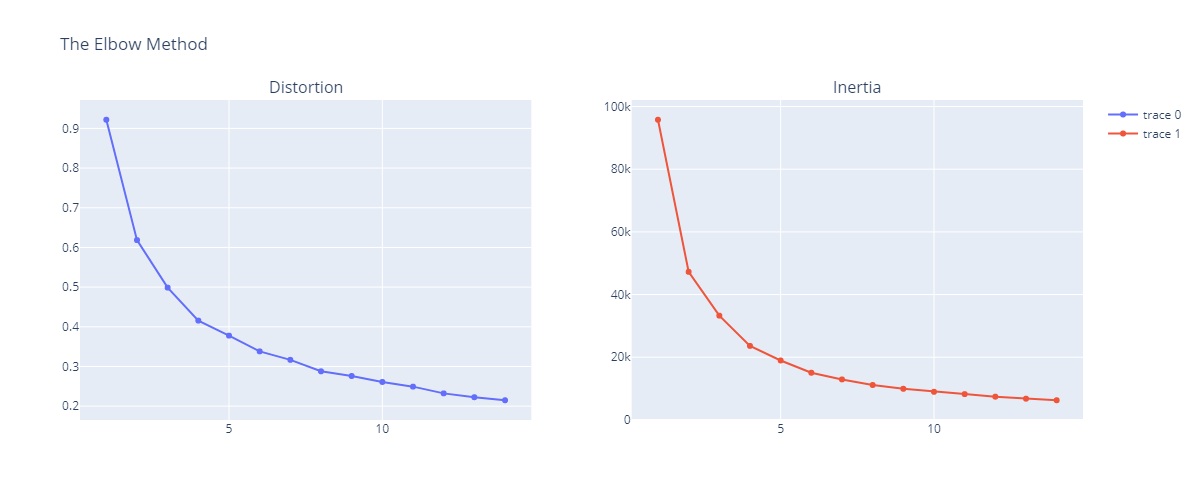

In [37]:
fig = make_subplots(
    rows=1, cols=2, subplot_titles=("Distortion", "Inertia")
)
fig.add_trace(go.Scatter(x=np.array(range(1, 15)), y=distortions), row=1, col=1)
fig.add_trace(go.Scatter(x=np.array(range(1, 15)), y=inertias), row=1, col=2)
fig.update_layout(title_text="The Elbow Method")
# fig.show(config=config)
Image(pio.to_image(fig, format='png', width=1200))

Based on the above plots we can see that 4 cluster value is optimal,b/c there is no significant decrease in distortion and inertia


In [39]:
kmeans = KMeans(n_clusters=4, random_state=0).fit(data_normalized)
user_engagement["Cluster"]= kmeans.labels_
user_engagement

,Cluster,Session_Frequency,Duration,Total_Data_Volume
Customer_Id,,,,
33601001722.00,2,1,116720.00,878690574.00
33601001754.00,3,1,181230.00,156859643.00
33601002511.00,3,1,134969.00,595966483.00
33601007832.00,0,1,49878.00,422320698.00
33601008617.00,1,2,37104.00,1457410944.00
...,...,...,...,...
33789996170.00,2,1,8810.00,714641641.00
33789997247.00,3,1,140988.00,480307335.00
3197020876596.00,0,1,86399.00,232123971.00


In [42]:
# save the models
import pickle
with open("../models/User_engagement.pkl", "wb") as f:
    pickle.dump(kmeans, f)

In [ ]:
#save th
user_engagement.to_csv('../data/user_engagement.csv')